In [1]:
from landmark_ensemble.functions import * 
import dill
from datetime import datetime

In [2]:
####################################################################################################################################

# settings 
dir = "/Users/pio/Google 드라이브/data/"
file_name = "pbc2.csv"
data = pd.read_csv(dir + file_name)

# drop status1 - competing risks setting
data = data.drop(axis=1, columns =['status'])


# ID, Time, Event, Measure Time column names
ID_col = 'id'; T_col ='years'; E_col ='status2'; measure_T_col = 'year'

# categorical variables
nominal_col = ['drug','sex', 'ascites', 'hepatomegaly','spiders', 'edema']
ordinal_col = ['histologic']

# continuous variables
cont_col = list(set(data.columns) - set(nominal_col) - set(ordinal_col) - set([ID_col, T_col, E_col, measure_T_col]))

# window - 5 year prediction 
window = 5

# S : landmark time points - 0, 0.5, 1, ..., 10
S = np.linspace(0,10,21)
v_years = S+window

# Number of bins when discritizing 
## !!!(Actually, k_bin - 1 bins are produced)!!!
k_bin = 5

# minimal bin_size
minimal_bin_size = window / (k_bin-1)

# 

# for continous variables, 
## scaling -> min-max scaling &
## imputation -> fill na's : median for continous
for col in cont_col : 
    data[col] = data[col].fillna(data[col].median())
    data[col] = (data[col] - min(data[col])) / (max(data[col]) - min(data[col]))

# one-hot encoding for categorical variables
data = pd.get_dummies(data, columns = nominal_col, drop_first=True)


####################################################################################################################################
# settings2

# proportion of train set
p_train = 0.7

# number of bagging
n_bagging = 30

In [3]:
## model specifics of level 0 models
cox_params = {'penalizer':np.exp(np.linspace(-5,1,5)),'l1_ratio':[0,0.25,0.5,0.75,1]}
# 5*5 *2 = 50
model_specifics_cont = pd.DataFrame({'model_name' : ['cox_str', 'cox_no_str'], 
                                'model_instance':[CoxPHFitter(),CoxPHFitter()], 
                                'hyperparams':[cox_params,cox_params], 
                                'type':['cox_str','cox_no_str']})

LR_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
} # 7 * 2 * 1 = 14
RF_params = {'n_estimators':[50,100,300,500],'max_depth':[1,3,5]} # 4*3 = 12
GB_params = {'n_estimators':[50,100,300,500],'max_depth':[1,3,5]} # 4*3 = 12
MLP_params = {'hidden_layer_sizes':[1,2], 'activation' : ['logistic', 'relu'], 'max_iter' : [1000], 'early_stopping' : [True], 'learning_rate' : ['adaptive']}
# 2*2 = 4
KNN_params = {'n_neighbors':[1,5,10], 'weights':['uniform', 'distance']} 
# 3*2
NGB_params = {'var_smoothing':[1e-5, 1e-9, 1e-1]}
# 3
ADA_params = {'n_estimators':[50, 100, 300, 500], 'max_depth':[1,3,5]}
# 4*3 = 12

model_specifics_disc = pd.DataFrame({'model_name' : ['LR','RF','GB','MLP','KNN','NGB','ADA'], 
                                'model_instance':[LogisticRegression(max_iter=10000),RandomForestClassifier(),GradientBoostingClassifier(),MLPClassifier(),KNeighborsClassifier(),GaussianNB(), AdaBoostClassifier()], 
                                'hyperparams':[LR_params, RF_params, GB_params,MLP_params, KNN_params,NGB_params, ADA_params], 
                                'type':['lr','rf','gb','mlp','knn','ngb','ada']})


model_specifics = pd.concat([model_specifics_cont,model_specifics_disc],axis=0).reset_index(drop=True)
model_specifics

,model_name,model_instance,hyperparams,type
0,cox_str,<lifelines.CoxPHFitter>,"{'penalizer': [0.006737946999085467, 0.0301973...",cox_str
1,cox_no_str,<lifelines.CoxPHFitter>,"{'penalizer': [0.006737946999085467, 0.0301973...",cox_no_str
2,LR,LogisticRegression(max_iter=10000),"{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'p...",lr
3,RF,RandomForestClassifier(),"{'n_estimators': [50, 100, 300, 500], 'max_dep...",rf
4,GB,GradientBoostingClassifier(),"{'n_estimators': [50, 100, 300, 500], 'max_dep...",gb
5,MLP,MLPClassifier(),"{'hidden_layer_sizes': [1, 2], 'activation': [...",mlp
6,KNN,KNeighborsClassifier(),"{'n_neighbors': [1, 5, 10], 'weights': ['unifo...",knn
7,NGB,GaussianNB(),"{'var_smoothing': [1e-05, 1e-09, 0.1]}",ngb
8,ADA,AdaBoostClassifier(),"{'n_estimators': [50, 100, 300, 500], 'max_dep...",ada


In [4]:
data_lm_cont = landmarker_cont(data=data, ID_col = ID_col, T_col = T_col, E_col = E_col, 
                window = window, S= S, measure_T_col = measure_T_col)

data_lm_disc = landmarker_disc(data=data_lm_cont,ID_col = ID_col, T_col = T_col, E_col = E_col, 
                window = window, S= S, measure_T_col = measure_T_col, k_bin = k_bin, train=True)

In [5]:
dir_save = '/Users/pio/Google 드라이브/github/survival ensemble/experiment/'
n_rep = 50

In [7]:
seed_list = list(range(50))
seed_list.remove(8) ; seed_list.remove(12); seed_list.remove(27)

In [11]:
brier_df_list = []; c_index_df_list = []; 
for seed_num in seed_list : 
    with open(dir_save +'seed_'+str(seed_num)+'_'+'brier_score.pkl', 'rb') as f : 
        brier_score = dill.load(f)

    with open(dir_save +'seed_'+str(seed_num)+'_'+'c_index_score.pkl', 'rb') as f : 
        c_index_score = dill.load(f)
                

    best_cox_idx = np.where(brier_score[list(range(50))].mean(axis=0) == brier_score[list(range(50))].mean(axis=0).min())[0][0]
    
    brier_df_list.append(pd.DataFrame({'model':'Cox','time':S ,'score': brier_score[best_cox_idx ]}))
    c_index_df_list.append(pd.DataFrame({'model':'Cox','time':S ,'score': c_index_score[best_cox_idx ]}))
        
    brier_df_list.append(pd.DataFrame({'model':'nnls','time':S ,'score': brier_score['nnls']}))
    c_index_df_list.append(pd.DataFrame({'model':'nnls','time':S ,'score': c_index_score['nnls']}))

    
    brier_df_list.append(pd.DataFrame({'model':'hill','time':S ,'score': brier_score['hill']}))
    c_index_df_list.append(pd.DataFrame({'model':'hill','time':S ,'score': c_index_score['hill']}))


    brier_df_list.append(pd.DataFrame({'model':'rf','time':S ,'score': brier_score['rf']}))
    c_index_df_list.append(pd.DataFrame({'model':'rf','time':S ,'score': c_index_score['rf']}))

    
    

In [13]:
brier_score_all_seed = pd.concat(brier_df_list,axis=0,ignore_index=True)
c_index_score_all_seed = pd.concat(c_index_df_list,axis=0,ignore_index=True)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# brier mean 비교

In [15]:
print(brier_score_all_seed[brier_score_all_seed['model'] == 'Cox'].score.mean())
print(brier_score_all_seed[brier_score_all_seed['model'] == 'Cox'].score.std())

0.14535286210510323
0.06289043286244478


In [16]:
print(brier_score_all_seed[brier_score_all_seed['model'] == 'nnls'].score.mean())
print(brier_score_all_seed[brier_score_all_seed['model'] == 'nnls'].score.std())

0.1594253036283166
0.05035974867521901


In [17]:
print(brier_score_all_seed[brier_score_all_seed['model'] == 'hill'].score.mean())
print(brier_score_all_seed[brier_score_all_seed['model'] == 'hill'].score.std())

0.14646359233855652
0.06824151344435812


In [18]:
print(brier_score_all_seed[brier_score_all_seed['model'] == 'rf'].score.mean())
print(brier_score_all_seed[brier_score_all_seed['model'] == 'rf'].score.std())

0.1588156827578714
0.08781056755185829


---

# c-index mean 비교

In [25]:
print(c_index_score_all_seed[c_index_score_all_seed['model'] == 'Cox'].score.mean())
print(c_index_score_all_seed[c_index_score_all_seed['model'] == 'Cox'].score.std())

0.8195758850132384
0.08032322695064935


In [26]:
print(c_index_score_all_seed[c_index_score_all_seed['model'] == 'nnls'].score.mean())
print(c_index_score_all_seed[c_index_score_all_seed['model'] == 'nnls'].score.std())

0.8264834216040831
0.07595158539339293


In [27]:
print(c_index_score_all_seed[c_index_score_all_seed['model'] == 'hill'].score.mean())
print(c_index_score_all_seed[c_index_score_all_seed['model'] == 'hill'].score.std())

0.829336569077785
0.07555861406953664


In [28]:
print(c_index_score_all_seed[c_index_score_all_seed['model'] == 'rf'].score.mean())
print(c_index_score_all_seed[c_index_score_all_seed['model'] == 'rf'].score.std())

0.8105873441489421
0.07789269903654167


<AxesSubplot:xlabel='time', ylabel='score'>

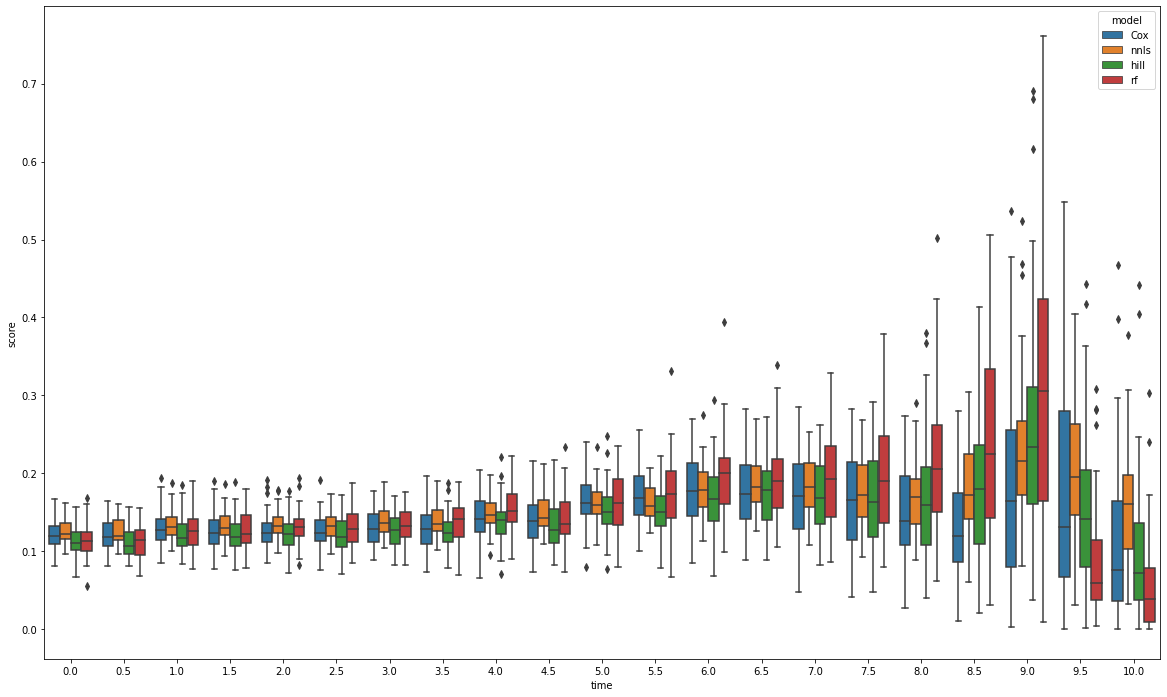

In [29]:
plt.figure(figsize=(20, 12))
sns.boxplot(data= brier_score_all_seed, x = 'time', y='score', hue = 'model')

<AxesSubplot:xlabel='time', ylabel='score'>

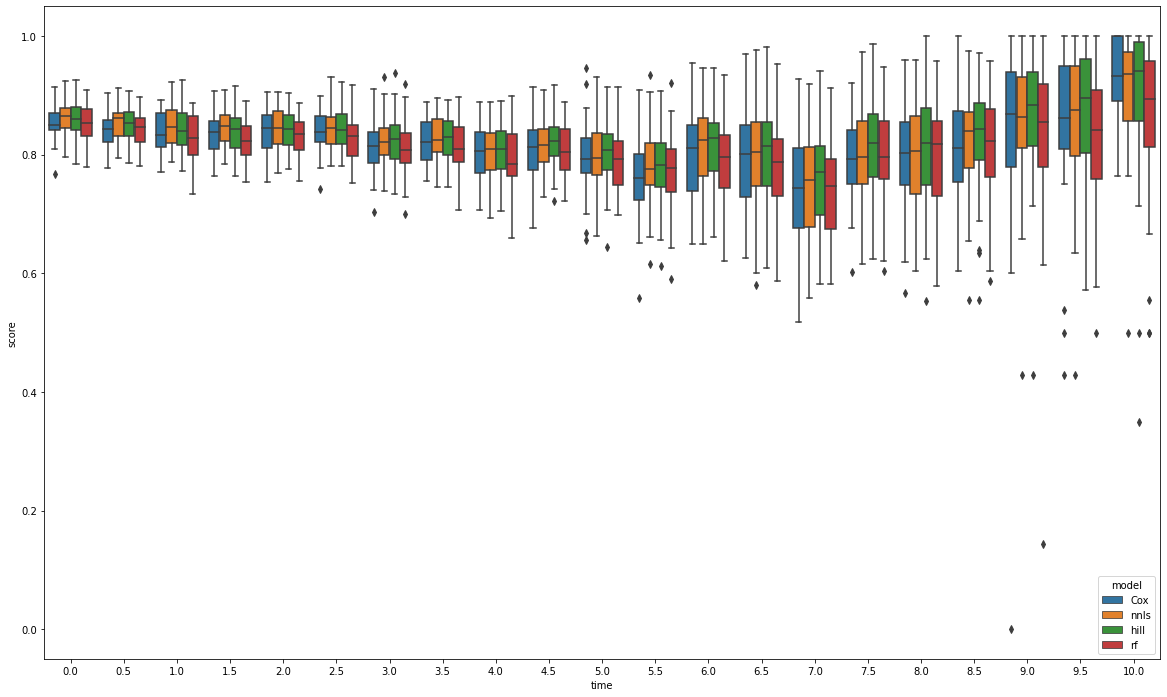

In [30]:
plt.figure(figsize=(20, 12))
sns.boxplot(data= c_index_score_all_seed, x = 'time', y='score', hue = 'model')

---

In [104]:
seed_num = 0
with open(dir_save +'seed_'+str(seed_num)+'_'+'brier_score.pkl', 'rb') as f : 
    brier_score = dill.load(f)

with open(dir_save +'seed_'+str(seed_num)+'_'+'c_index_score.pkl', 'rb') as f : 
    c_index_score = dill.load(f)

c_index_max_idx_seed_0 = np.where(c_index_score[list(range(50))].mean(axis=0) == c_index_score[list(range(50))].mean(axis=0).max())[0][0]

c_index_max_idx_seed_0

28

In [106]:
brier_df_list = []; c_index_df_list = []; 
for seed_num in seed_list : 
    with open(dir_save +'seed_'+str(seed_num)+'_'+'brier_score.pkl', 'rb') as f : 
        brier_score = dill.load(f)

    with open(dir_save +'seed_'+str(seed_num)+'_'+'c_index_score.pkl', 'rb') as f : 
        c_index_score = dill.load(f)

#    c_index_max_idx = np.where(c_index_score[list(range(50))].mean(axis=0) == c_index_score[list(range(50))].mean(axis=0).max())[0][0]
    c_index_max_idx = c_index_max_idx_seed_0
    
    brier_df_list.append(pd.DataFrame({'model':'Cox','time':S ,'score': brier_score[c_index_max_idx]}))
    c_index_df_list.append(pd.DataFrame({'model':'Cox','time':S ,'score': c_index_score[c_index_max_idx]}))
        
    brier_df_list.append(pd.DataFrame({'model':'nnls','time':S ,'score': brier_score['nnls']}))
    c_index_df_list.append(pd.DataFrame({'model':'nnls','time':S ,'score': c_index_score['nnls']}))

    
    brier_df_list.append(pd.DataFrame({'model':'hill','time':S ,'score': brier_score['hill']}))
    c_index_df_list.append(pd.DataFrame({'model':'hill','time':S ,'score': c_index_score['hill']}))


    brier_df_list.append(pd.DataFrame({'model':'rf','time':S ,'score': brier_score['rf']}))
    c_index_df_list.append(pd.DataFrame({'model':'rf','time':S ,'score': c_index_score['rf']}))

    
brier_score_all_seed = pd.concat(brier_df_list,axis=0,ignore_index=True)
c_index_score_all_seed = pd.concat(c_index_df_list,axis=0,ignore_index=True)    

<AxesSubplot:xlabel='time', ylabel='score'>

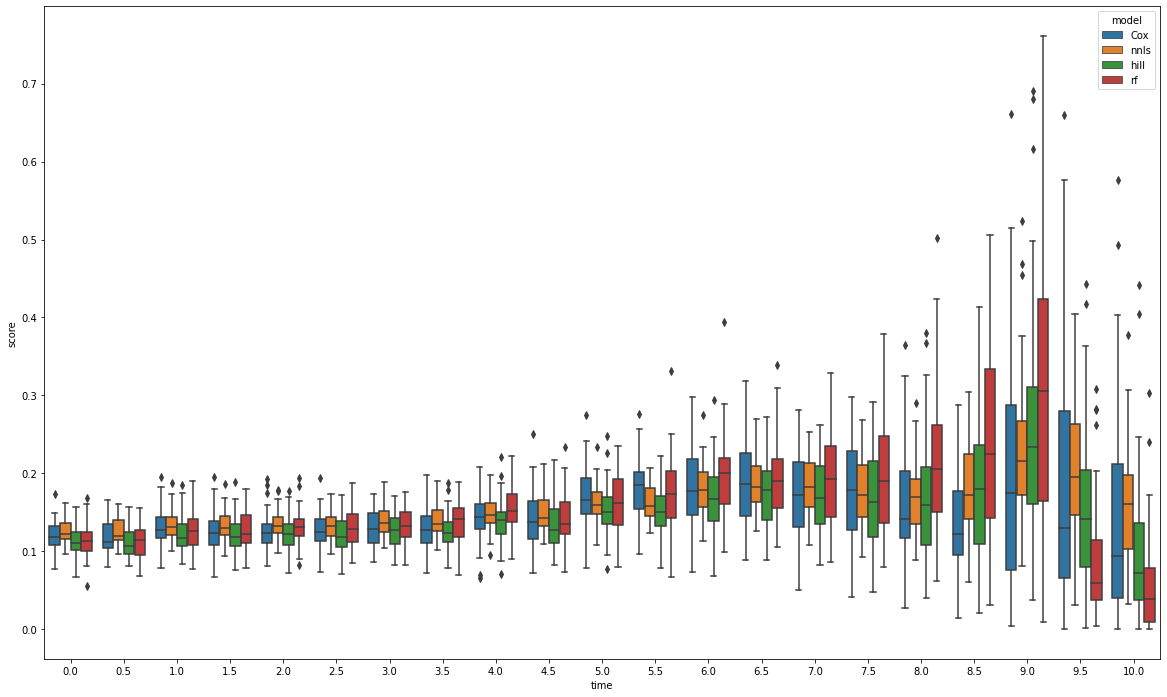

In [107]:
plt.figure(figsize=(20, 12))
sns.boxplot(data= brier_score_all_seed, x = 'time', y='score', hue = 'model')

<AxesSubplot:xlabel='time', ylabel='score'>

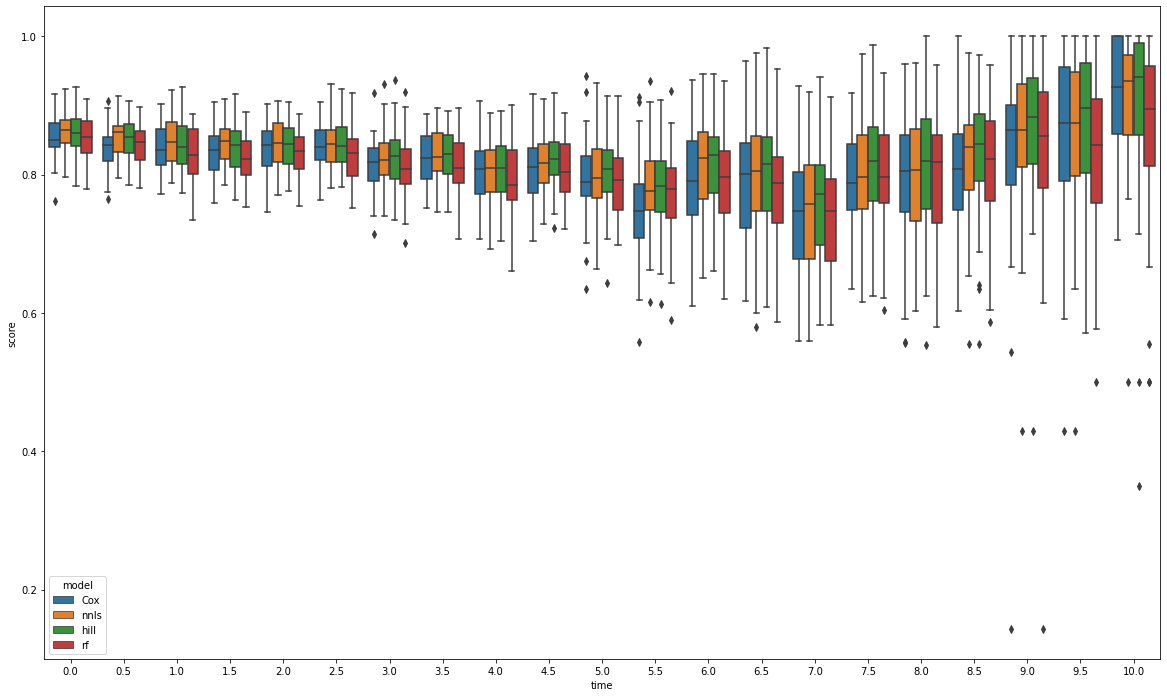

In [108]:
plt.figure(figsize=(20, 12))
sns.boxplot(data= c_index_score_all_seed, x = 'time', y='score', hue = 'model')

---

Ensemble selection